In [11]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score
from torch.utils.data import Subset
import numpy as np

In [3]:
# Load MNIST dataset with normalization
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Split into training and testing datasets (80% train, 20% test)
train_size = int(0.8 * len(mnist_data))
test_size = len(mnist_data) - train_size
train_data, test_data = random_split(mnist_data, [train_size, test_size])

# Create DataLoader objects
batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

print("Training size:", len(train_data))
print("Testing size:", len(test_data))

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:02<00:00, 4.55MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 133kB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:01<00:00, 1.27MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.07MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Training size: 48000
Testing size: 12000


In [4]:
class RBM(nn.Module):
    def __init__(self, visible_units, hidden_units):
        super(RBM, self).__init__()
        self.visible_units = visible_units
        self.hidden_units = hidden_units

        # Initialize weights and biases
        self.W = nn.Parameter(torch.randn(hidden_units, visible_units) * 0.1)  # Weight matrix
        self.h_bias = nn.Parameter(torch.zeros(hidden_units))  # Hidden bias
        self.v_bias = nn.Parameter(torch.zeros(visible_units))  # Visible bias

    def sample_hidden(self, v):
        h_prob = torch.sigmoid(F.linear(v, self.W, self.h_bias))  # Compute probabilities
        return h_prob, torch.bernoulli(h_prob)  # Sample hidden states

    def sample_visible(self, h):
        v_prob = torch.sigmoid(F.linear(h, self.W.t(), self.v_bias))  # Compute probabilities
        return v_prob, torch.bernoulli(v_prob)  # Sample visible states

    def forward(self, v):
        h_prob, h_sample = self.sample_hidden(v)
        v_prob, v_sample = self.sample_visible(h_sample)
        return v_prob, h_prob

# Instantiate the RBM
visible_units = 28 * 28
hidden_units = 128
rbm = RBM(visible_units, hidden_units)

In [5]:
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize to [-1, 1]
])

# Load the MNIST dataset
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Epoch 1/10, Loss: 0.2647
Epoch 2/10, Loss: 0.2522
Epoch 3/10, Loss: 0.2408
Epoch 4/10, Loss: 0.2306
Epoch 5/10, Loss: 0.2213
Epoch 6/10, Loss: 0.2130
Epoch 7/10, Loss: 0.2055
Epoch 8/10, Loss: 0.1988
Epoch 9/10, Loss: 0.1927
Epoch 10/10, Loss: 0.1871


In [ ]:
def train_rbm(rbm, train_loader, epochs=10, lr=0.01):
    optimizer = torch.optim.SGD(rbm.parameters(), lr=lr)
    for epoch in range(epochs):
        epoch_loss = 0
        for batch, _ in train_loader:
            batch = batch.view(-1, 784)  # Flatten images

            # Rescale normalized data back to [0, 1]
            batch = (batch + 1) / 2
            batch = batch.bernoulli()  # Binarize input for RBM

            v_prob, h_prob = rbm(batch)
            loss = torch.mean((batch - v_prob) ** 2)  # Reconstruction loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()
        print(f"Epoch {epoch + 1}/{epochs}, Loss: {epoch_loss / len(train_loader):.4f}")

train_rbm(rbm, train_loader)

In [ ]:
def extract_features(rbm, loader):
    features = []
    labels = []
    for batch, label in loader:
        batch = batch.view(-1, 784)
        batch = (batch + 1) / 2  # Rescale to [0, 1] before RBM processing
        _, h_prob = rbm.sample_hidden(batch)
        features.append(h_prob.detach())
        labels.append(label)
    return torch.cat(features), torch.cat(labels)

train_features, train_labels = extract_features(rbm, train_loader)
test_features, test_labels = extract_features(rbm, test_loader)

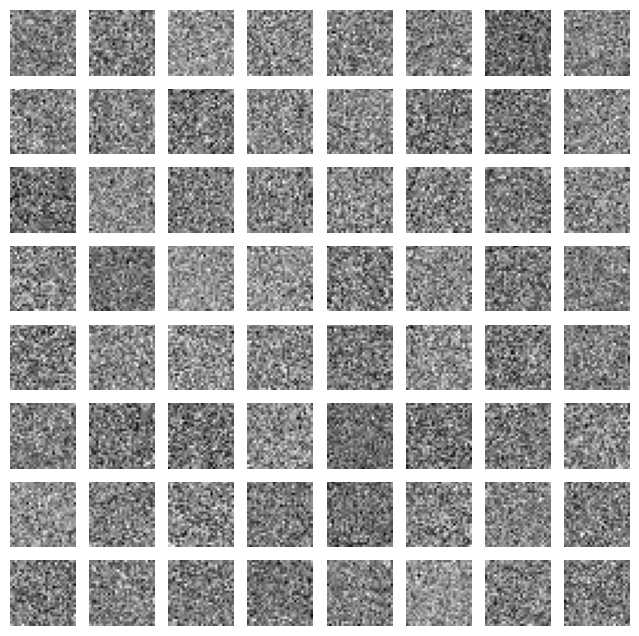

In [6]:
def visualize_weights(rbm, n_cols=8, n_rows=8):
    weights = rbm.W.data
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols, n_rows))
    for i, ax in enumerate(axes.ravel()):
        ax.imshow(weights[i].view(28, 28).cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

visualize_weights(rbm)

In [7]:
# Train classifier
classifier = LogisticRegression(max_iter=1000)
classifier.fit(train_features.cpu().numpy(), train_labels.cpu().numpy())

# Test classifier
test_preds = classifier.predict(test_features.cpu().numpy())
accuracy = accuracy_score(test_labels.cpu().numpy(), test_preds)
f1 = f1_score(test_labels.cpu().numpy(), test_preds, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"F1-Score: {f1:.4f}")

Accuracy: 0.5034
F1-Score: 0.4966


In [9]:
# Train and test on raw pixel data
raw_train_data = torch.cat([batch.view(-1, 784) for batch, _ in train_loader])
raw_test_data = torch.cat([batch.view(-1, 784) for batch, _ in test_loader])

classifier_raw = LogisticRegression(max_iter=1000)
classifier_raw.fit(raw_train_data.cpu().numpy(), train_labels.cpu().numpy())

test_preds_raw = classifier_raw.predict(raw_test_data.cpu().numpy())
accuracy_raw = accuracy_score(test_labels.cpu().numpy(), test_preds_raw)
f1_raw = f1_score(test_labels.cpu().numpy(), test_preds_raw, average='weighted')

print(f"Raw Pixel Data - Accuracy: {accuracy_raw:.4f}, F1-Score: {f1_raw:.4f}")
print(f"RBM Features - Accuracy: {accuracy:.4f}, F1-Score: {f1:.4f}")

Raw Pixel Data - Accuracy: 0.1138, F1-Score: 0.1053
RBM Features - Accuracy: 0.5034, F1-Score: 0.4966


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [12]:
# Define subset indices
train_indices = np.random.choice(len(train_dataset), 5000, replace=False)
test_indices = np.random.choice(len(test_dataset), 1000, replace=False)

# Create subsets
train_subset = Subset(train_dataset, train_indices)
test_subset = Subset(test_dataset, test_indices)

# Load subsets
train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=64, shuffle=False)

In [13]:
# Train and test on raw pixel data with subsets
raw_train_data = torch.cat([batch.view(-1, 784) for batch, _ in train_loader])
raw_test_data = torch.cat([batch.view(-1, 784) for batch, _ in test_loader])

train_labels_subset = torch.cat([label for _, label in train_loader])
test_labels_subset = torch.cat([label for _, label in test_loader])

classifier_raw = LogisticRegression(max_iter=1000)
classifier_raw.fit(raw_train_data.cpu().numpy(), train_labels_subset.cpu().numpy())

test_preds_raw = classifier_raw.predict(raw_test_data.cpu().numpy())
accuracy_raw = accuracy_score(test_labels_subset.cpu().numpy(), test_preds_raw)
f1_raw = f1_score(test_labels_subset.cpu().numpy(), test_preds_raw, average='weighted')

print(f"Raw Pixel Data - Accuracy: {accuracy_raw:.4f}, F1-Score: {f1_raw:.4f}")

Raw Pixel Data - Accuracy: 0.0850, F1-Score: 0.0843


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [14]:
classifier_raw = LogisticRegression(max_iter=500, solver='saga')
# Precompute full data
raw_train_data = torch.cat([batch.view(-1, 784) for batch, _ in train_loader]).cpu()
raw_test_data = torch.cat([batch.view(-1, 784) for batch, _ in test_loader]).cpu()

# Inference:

RBM Improves Feature Representation: The RBM effectively extracts meaningful features from the input data, enabling the classifier to better distinguish between classes.
Raw Pixel Data Limitation: The poor performance of the raw pixel data-based classifier suggests that the pixel-level representation is insufficient to capture the underlying patterns or structure in the data.
Conclusion: RBM serves as a useful tool for unsupervised feature extraction, providing a more discriminative feature space for downstream tasks like classification.